RUNNING SLSQP WITH EQUALITY CONSTRAINT...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.9956766243228465
            Iterations: 51
            Function evaluations: 5152
            Gradient evaluations: 51
Optimization done. success = True
Final objective: -0.9956766243228465
Initial color-axis norm = 51.3160
Final color-axis norm   = 51.3160 (difference: 6.4508e-09)
Angle pre-mod = 10.735 deg [with v_target]
Angle post-mod = 3.770 deg [with v_target]
Angle improvement = 6.965 deg


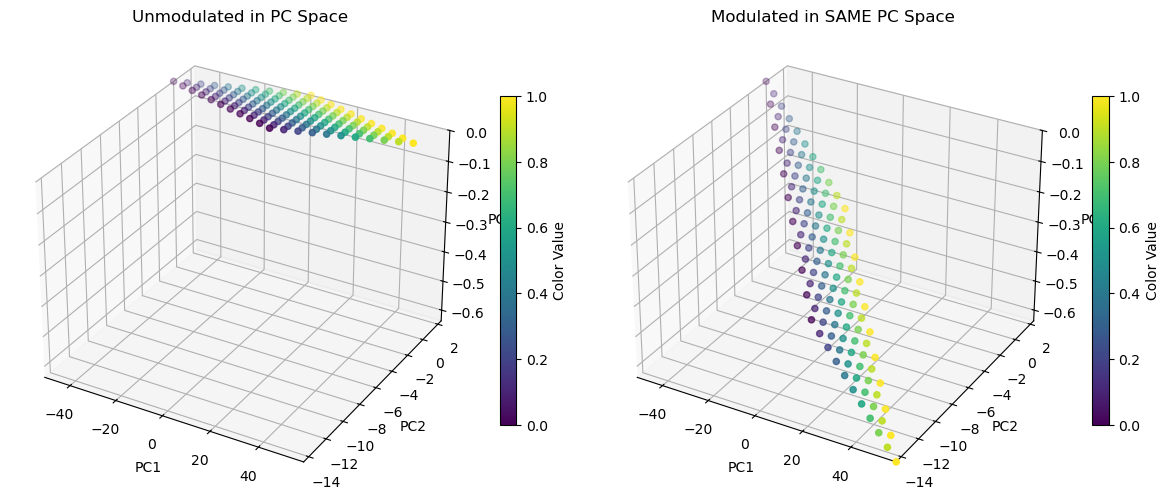

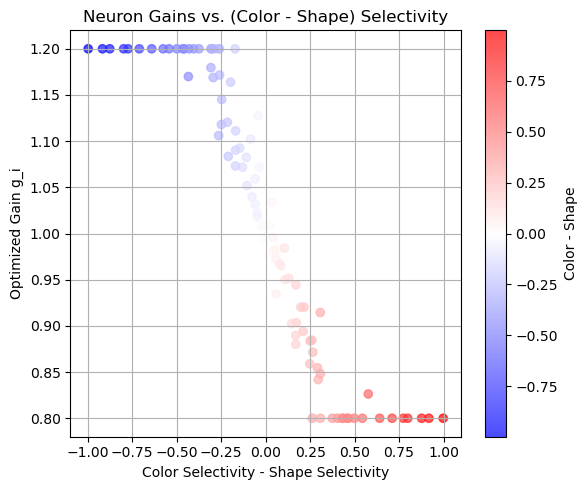

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from scipy.optimize import minimize

np.random.seed(15)
N = 100
K = 2  # shape=0, color=1
desired_radius = 0.9
p_high = 0.2
p_low = 0.2

# -------------------------------------------------
# 1) Initialization
# -------------------------------------------------
def initialize_selectivity_matrix(N, K):
    """
    Half are shape-based, half are color-based, with a random distribution.
    """
    S = np.zeros((N, K))
    S[:N//2, 0] = np.random.rand(N//2)
    S[:N//2, 1] = 0.5 - S[:N//2, 0] / 2
    neg_idx = (S[:N//2, 0] - S[:N//2, 1]) < 0
    S[:N//2, 0][neg_idx] = np.random.uniform(0, 0.5, size=np.sum(neg_idx))
    S[N//2:, 1] = S[:N//2, 0]
    S[N//2:, 0] = S[:N//2, 1]
    return S

def initialize_W_F(S):
    """
    W_F divides each neuron's (shape,color) by its sum.
    """
    W_F = np.zeros_like(S)
    for i in range(S.shape[0]):
        r = np.sum(S[i])
        if r > 0:
            W_F[i] = S[i] / r
        else:
            W_F[i] = S[i]
    return W_F

def initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=0.9):
    """
    Build a recurrent matrix with four blocks and scale it.
    """
    W_R = np.zeros((N, N))
    halfN = N // 2

    ss_mask = np.random.rand(halfN, halfN) < p_high
    W_R[:halfN, :halfN][ss_mask] = np.random.rand(np.sum(ss_mask)) * 0.1

    sc_mask = np.random.rand(halfN, N - halfN) < p_low
    W_R[:halfN, halfN:][sc_mask] = np.random.rand(np.sum(sc_mask)) * 0.1

    cs_mask = np.random.rand(N - halfN, halfN) < p_low
    W_R[halfN:, :halfN][cs_mask] = np.random.rand(np.sum(cs_mask)) * 0.1

    cc_mask = np.random.rand(N - halfN, N - halfN) < p_high
    W_R[halfN:, halfN:][cc_mask] = np.random.rand(np.sum(cc_mask)) * 0.1

    np.fill_diagonal(W_R, 0)

    if WR_tuned:
        thresh = 0.2
        for i in range(N):
            for j in range(N):
                if i != j:
                    d = np.linalg.norm(S[i] - S[j])
                    if d < thresh:
                        W_R[i, j] *= (2 - d / thresh)

    # Rescale W_R so spectral radius = desired_radius
    eivals = np.linalg.eigvals(W_R)
    max_ev = np.max(np.abs(eivals))
    if max_ev > 0:
        W_R *= (desired_radius / max_ev)
    return W_R

# -------------------------------------------------
# 2) Response Computations
# -------------------------------------------------
def compute_response(W_R, W_F, shape_val, color_val, g_vector=None):
    """
    Returns steady-state response for a single (shape_val, color_val).
    """
    I = np.eye(W_R.shape[0])
    if g_vector is None:
        inv_mat = np.linalg.inv(I - W_R)
        WF_eff = W_F
    else:
        G = np.diag(g_vector)
        inv_mat = np.linalg.inv(I - G @ W_R)
        WF_eff = G @ W_F

    F = np.array([shape_val, color_val])
    return inv_mat @ (WF_eff @ F)

def compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=None):
    """
    Returns a [num_shape * num_color, N] array of responses
    by scanning over shape_vals x color_vals.
    """
    responses = []
    for s in shape_vals:
        for c in color_vals:
            resp = compute_response(W_R, W_F, s, c, g_vector)
            responses.append(resp)
    return np.array(responses)

# ================================================================
# MAIN SCRIPT
# ================================================================
if __name__ == "__main__":
    # 1) Create the network
    S = initialize_selectivity_matrix(N, K)
    W_F = initialize_W_F(S)
    W_R = initialize_W_R(N, p_high, p_low, S, WR_tuned=False, desired_radius=desired_radius)

    # 2) Build a 2D grid of shape & color
    grid_points = 11
    shape_vals = np.linspace(0, 1, grid_points)
    color_vals = np.linspace(0, 1, grid_points)

    # For coloring the grid in plots, we need to track the color param for each point
    color_list = []
    for s in shape_vals:
        for c in color_vals:
            color_list.append(c)
    color_list = np.array(color_list)  # shape [121,]

    # 2.1) Compute unmodulated responses for entire grid
    responses_grid_unmod = compute_grid_responses(
        W_R, W_F, shape_vals, color_vals, g_vector=None
    )
    # shape => [121, N]

    # 2.2) PCA on unmodulated grid responses, keep 3 PCs
    pca_grid = PCA(n_components=3)
    pca_grid.fit(responses_grid_unmod)  # shape = [121, N]
    pc_basis = pca_grid.components_  # shape [3, N]

    # We'll define:
    #   v1 as the first PC (normalized)
    #   v2 as the second PC (normalized)
    v1 = pc_basis[0].copy()
    v1 /= np.linalg.norm(v1)
    v2 = pc_basis[1].copy()
    v2 /= np.linalg.norm(v2)

    # -----------------------------
    # >>> Define the target vector:
    # -----------------------------
    # Suppose we want a 10-degree rotation from v1 toward v2 in the v1-v2 plane:
    theta_deg = -8.0
    theta = np.deg2rad(theta_deg)
    v_target = v1 * np.cos(theta) + v2 * np.sin(theta)
    v_target /= np.linalg.norm(v_target)

    # 3) For the color-axis alignment, pick shape=0.3
    shape_for_color_line = 0.3

    def color_axis_direction(g):
        """
        For a given g-vector, define color-axis as difference between
        response at color=1.0 and color=0.0 for shape=0.3.
        """
        resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
        resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
        return resp_c1 - resp_c0

    # 3.1) Compute unmodulated color axis (for norm reference):
    init_g = np.ones(N)
    d_unmod = color_axis_direction(init_g)
    norm_unmod_sq = np.linalg.norm(d_unmod)**2

    # 4) Objective: maximize cos^2 w.r.t. v_target => minimize negative cos^2
    def alignment_objective_angle_only(g):
        d_col = color_axis_direction(g)
        dot_val = np.dot(v_target, d_col)
        denom = np.linalg.norm(d_col) * np.linalg.norm(v_target)
        if denom < 1e-15:
            return 0.0  # degenerate
        cos_val = dot_val / denom
        # We want to maximize cos^2 => minimize the negative
        return -(cos_val**2)

    # 4.1) Exact constraint: keep ||d_col||^2 == ||d_unmod||^2
    def color_axis_norm_constraint(g):
        d_col = color_axis_direction(g)
        return np.linalg.norm(d_col)**2 - norm_unmod_sq

    # 5) Solve using SLSQP for exact equality + box constraints
    from scipy.optimize import Bounds
    L, U = 0.80, 1.20
    bounds = Bounds([L]*N, [U]*N)

    constraint_eq = {
        'type': 'eq',
        'fun': color_axis_norm_constraint
    }

    print("RUNNING SLSQP WITH EQUALITY CONSTRAINT...")
    res = minimize(
        fun=alignment_objective_angle_only,
        x0=init_g,
        method='SLSQP',
        bounds=bounds,
        constraints=[constraint_eq],
        options={'maxiter': 300, 'disp': True}
    )

    g_opt = res.x
    print("Optimization done. success =", res.success)
    print("Final objective:", res.fun)

    # 5.1) Compare angles pre vs. post
    def angle_with_v(v, d_vec):
        """
        Returns the minimal angle (in deg) between v and d_vec
        ignoring sign (i.e. 0 deg vs 180 deg is the same axis).
        """
        dot_v = np.dot(v, d_vec)
        denom = np.linalg.norm(v)*np.linalg.norm(d_vec)
        if denom < 1e-15:
            return np.nan
        val = dot_v / denom
        val = np.clip(val, -1, 1)
        angle_deg = np.degrees(np.arccos(val))
        return min(angle_deg, 180.0 - angle_deg)

    d_mod = color_axis_direction(g_opt)
    angle_pre = angle_with_v(v_target, d_unmod)
    angle_post = angle_with_v(v_target, d_mod)

    # Check final norm
    final_norm = np.linalg.norm(d_mod)
    init_norm = np.sqrt(norm_unmod_sq)
    print(f"Initial color-axis norm = {init_norm:.4f}")
    print(f"Final color-axis norm   = {final_norm:.4f} (difference: {final_norm - init_norm:.4e})")

    print(f"Angle pre-mod = {angle_pre:.3f} deg [with v_target]")
    print(f"Angle post-mod = {angle_post:.3f} deg [with v_target]")
    print(f"Angle improvement = {angle_pre - angle_post:.3f} deg")

    # ---------------------------------------------------------
    # 6) Visualization
    # ---------------------------------------------------------
    responses_grid_mod = compute_grid_responses(W_R, W_F, shape_vals, color_vals, g_vector=g_opt)

    proj_unmod = pca_grid.transform(responses_grid_unmod)  # shape [121, 3]
    proj_mod = pca_grid.transform(responses_grid_mod)      # shape [121, 3]

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Unmodulated in PC Space")
    sc1 = ax1.scatter(proj_unmod[:,0], proj_unmod[:,1], proj_unmod[:,2],
                      c=color_list, cmap='viridis', s=20)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Modulated in SAME PC Space")
    sc2 = ax2.scatter(proj_mod[:,0], proj_mod[:,1], proj_mod[:,2],
                      c=color_list, cmap='viridis', s=20)
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")

    x_min = min(proj_unmod[:,0].min(), proj_mod[:,0].min())
    x_max = max(proj_unmod[:,0].max(), proj_mod[:,0].max())
    y_min = min(proj_unmod[:,1].min(), proj_mod[:,1].min())
    y_max = max(proj_unmod[:,1].max(), proj_mod[:,1].max())
    z_min = min(proj_unmod[:,2].min(), proj_mod[:,2].min())
    z_max = max(proj_unmod[:,2].max(), proj_mod[:,2].max())
    for ax in [ax1, ax2]:
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_zlim([z_min, z_max])

    cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
    cb1.set_label("Color Value")
    cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
    cb2.set_label("Color Value")

    plt.tight_layout()
    plt.show()

    # 6.2) Scatter: (color_selectivity - shape_selectivity) vs. g_opt
    color_diff = S[:,1] - S[:,0]

    fig2 = plt.figure(figsize=(6,5))
    plt.scatter(color_diff, g_opt, alpha=0.7, c=color_diff, cmap='bwr')
    plt.xlabel("Color Selectivity - Shape Selectivity")
    plt.ylabel("Optimized Gain g_i")
    plt.title("Neuron Gains vs. (Color - Shape) Selectivity")
    cb = plt.colorbar()
    cb.set_label("Color - Shape")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [2]:
# Suppose you have already defined:
#   - v_target: the target PC vector (unit normalized)
#   - d_unmod : the color-axis vector before modulation
#   - d_mod   : the color-axis vector after modulation

# Scalar projection of "d_unmod" onto "v_target":
proj_before = np.dot(d_unmod, v_target) / np.linalg.norm(v_target)

# Scalar projection of "d_mod" onto "v_target":
proj_after = np.dot(d_mod, v_target) / np.linalg.norm(v_target)

print(f"Projection onto v_target before: {proj_before:.4f}")
print(f"Projection onto v_target after : {proj_after:.4f}")


Projection onto v_target before: 50.4180
Projection onto v_target after : 51.2050


Angle post-mod (shuffled) = 5.206 deg


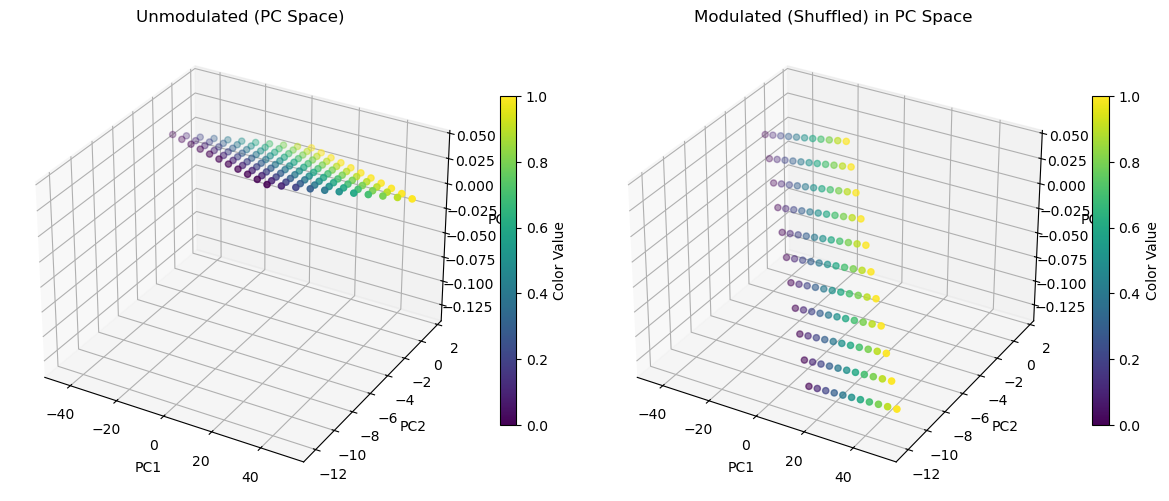

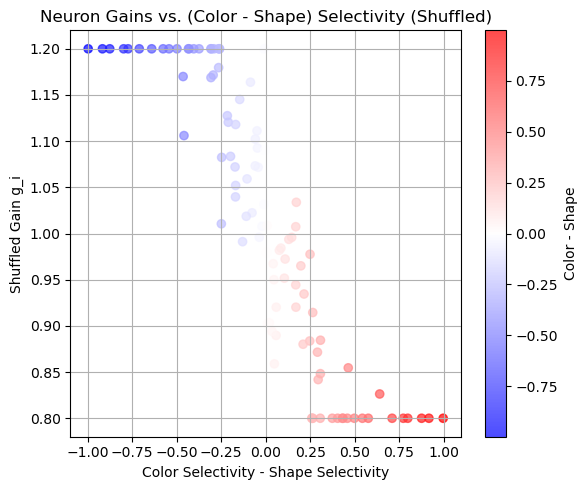

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------
# 1) BIN AND SHUFFLE g_opt
# -----------------------------------
bin_size = 0.25
# Build bin edges that cover the range of color_diff.
# You might want to adjust min/max depending on your data distribution.
min_cd = color_diff.min()
max_cd = color_diff.max()

bin_edges = np.arange(-1.0, 1.01, bin_size)  # For example, from -1 to +1 in steps of 0.25
# (Adjust the range so that it surely covers your color_diff values.)

# Digitize color_diff to find bin indices
bin_idx = np.digitize(color_diff, bin_edges) - 1  # so that bin_idx starts from 0

g_opt_shuffled = np.zeros_like(g_opt)

# For each bin, shuffle the g_opt among the neurons in that bin
unique_bins = np.unique(bin_idx)
for b in unique_bins:
    # Indices of neurons that fall into bin 'b'
    idx_in_bin = np.where(bin_idx == b)[0]
    
    if len(idx_in_bin) > 1:
        # Shuffle their gains
        shuffled_bin_vals = np.random.permutation(g_opt[idx_in_bin])
        g_opt_shuffled[idx_in_bin] = shuffled_bin_vals
    elif len(idx_in_bin) == 1:
        # If there's exactly 1 neuron in that bin, no permutation is needed
        g_opt_shuffled[idx_in_bin] = g_opt[idx_in_bin]
    # If 0 neurons, do nothing

# -----------------------------------
# 2) RECOMPUTE RESPONSES WITH SHUFFLED G
# -----------------------------------
responses_grid_mod_shuffled = compute_grid_responses(
    W_R, W_F, shape_vals, color_vals, g_vector=g_opt_shuffled
)
proj_mod_shuffled = pca_grid.transform(responses_grid_mod_shuffled)  # shape [121, 3]

# -----------------------------------
# 3) CHECK NEW ANGLE WITH v1
# -----------------------------------
def color_axis_direction(g):
    # reusing the same shape_for_color_line = 0.3 from your code
    resp_c0 = compute_response(W_R, W_F, shape_for_color_line, 0.0, g)
    resp_c1 = compute_response(W_R, W_F, shape_for_color_line, 1.0, g)
    return resp_c1 - resp_c0

d_mod_shuf = color_axis_direction(g_opt_shuffled)

def angle_with_v1(d_vec):
    dot_v = np.dot(v_target, d_vec)
    denom = np.linalg.norm(v1)*np.linalg.norm(d_vec)
    if denom < 1e-15:
        return np.nan
    val = dot_v / denom
    val = np.clip(val, -1, 1)
    angle_deg = np.degrees(np.arccos(val))
    # consider 0 deg vs. 180 deg to be the same axis => pick smaller
    return min(angle_deg, 180.0 - angle_deg)

angle_post_shuf = angle_with_v1(d_mod_shuf)
print(f"Angle post-mod (shuffled) = {angle_post_shuf:.3f} deg")

# -----------------------------------
# 4) VISUALIZE 3D SCATTER IN THE SAME PC BASIS
# -----------------------------------
fig = plt.figure(figsize=(12,5))

# We'll reuse the proj_unmod from earlier, or replot from scratch
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Unmodulated (PC Space)")
sc1 = ax1.scatter(proj_unmod[:,0], proj_unmod[:,1], proj_unmod[:,2],
                  c=color_list, cmap='viridis', s=20)
ax1.set_xlabel("PC1"); ax1.set_ylabel("PC2"); ax1.set_zlabel("PC3")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Modulated (Shuffled) in PC Space")
sc2 = ax2.scatter(proj_mod_shuffled[:,0], proj_mod_shuffled[:,1], proj_mod_shuffled[:,2],
                  c=color_list, cmap='viridis', s=20)
ax2.set_xlabel("PC1"); ax2.set_ylabel("PC2"); ax2.set_zlabel("PC3")

# Match axis limits across subplots
x_min = min(proj_unmod[:,0].min(), proj_mod_shuffled[:,0].min())
x_max = max(proj_unmod[:,0].max(), proj_mod_shuffled[:,0].max())
y_min = min(proj_unmod[:,1].min(), proj_mod_shuffled[:,1].min())
y_max = max(proj_unmod[:,1].max(), proj_mod_shuffled[:,1].max())
z_min = min(proj_unmod[:,2].min(), proj_mod_shuffled[:,2].min())
z_max = max(proj_unmod[:,2].max(), proj_mod_shuffled[:,2].max())

for ax in [ax1, ax2]:
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

cb1 = plt.colorbar(sc1, ax=ax1, shrink=0.7)
cb1.set_label("Color Value")
cb2 = plt.colorbar(sc2, ax=ax2, shrink=0.7)
cb2.set_label("Color Value")

plt.tight_layout()
plt.show()

# -----------------------------------
# 5) SCATTER: color_diff vs. g_opt_shuffled
# -----------------------------------
fig2 = plt.figure(figsize=(6,5))
plt.scatter(color_diff, g_opt_shuffled, alpha=0.7, c=color_diff, cmap='bwr')
plt.xlabel("Color Selectivity - Shape Selectivity")
plt.ylabel("Shuffled Gain g_i")
plt.title("Neuron Gains vs. (Color - Shape) Selectivity (Shuffled)")
cb = plt.colorbar()
cb.set_label("Color - Shape")
plt.grid(True)
plt.tight_layout()
plt.show()
